In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt


In [ ]:
torch.manual_seed(42)

In [ ]:
!pip install -q kaggle



In [ ]:
# Upload your kaggle.json
from google.colab import files
files.upload('')



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saarthakgupta2006","key":"fa6ade5647fa61b722cba93a67c7d0ff"}'}

In [ ]:
# Set up API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#

In [ ]:
 #Download dataset (change to your dataset)
!kaggle datasets download -d oddrationale/mnist-in-csv

Dataset URL: https://www.kaggle.com/datasets/oddrationale/mnist-in-csv
License(s): CC0-1.0
  0% 0.00/15.2M [00:00<?, ?B/s]
100% 15.2M/15.2M [00:00<00:00, 1.17GB/s]


In [ ]:
! unzip /content/mnist-in-csv.zip

Archive:  /content/mnist-in-csv.zip
  inflating: mnist_test.csv          
  inflating: mnist_train.csv         


In [ ]:
import pandas as pd

file_path_1 = '/content/mnist_train.csv'
file_path_2 = '/content/mnist_test.csv'

df1 = pd.read_csv(file_path_1)
df2 = pd.read_csv(file_path_2)
df1.head()


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(df1.shape)
print(df2.shape)

(60000, 785)
(10000, 785)


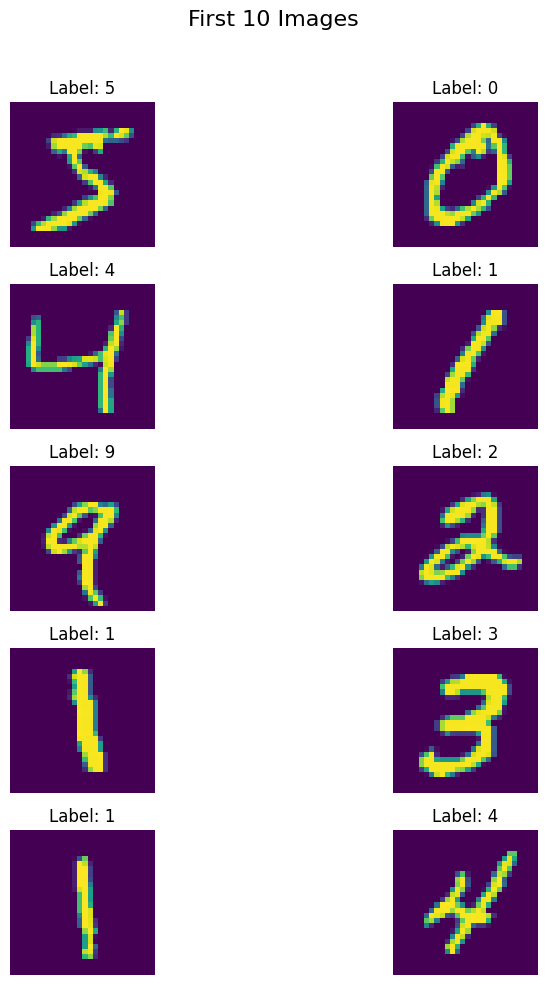

In [ ]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
fig.suptitle("First 10 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df1.iloc[i, 1:].values.reshape(28,28,1)  # Reshape to
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df1.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


In [ ]:
# train test data

X_train = df1.iloc[:, 1:].values
y_train = df1.iloc[:, 0].values
X_test = df2.iloc[:, 1:].values
y_test = df2.iloc[:, 0].values

In [ ]:
X_train = X_train/255.0
X_test = X_test/255.0

In [ ]:
class CustomDataset(Dataset):
    def __init__ (self,features,targets,transform=None):
      self.features = torch.tensor(features,dtype=torch.float32).reshape(-1, 1, 28, 28)
      self.targets=torch.tensor(targets,dtype=torch.long)

    def __len__(self):
      return self.features.shape[0]

    def __getitem__(self,idx):
      return self.features[idx],self.targets[idx]

In [ ]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32 ,shuffle=False, pin_memory=True)
batch_size=32

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, Number_of_classes):
        super().__init__()
        self.features=nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,stride=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(32,64,kernel_size=3,padding='same'),
            nn.ReLU(),
            nn.Conv2d(64,128,kernel_size=3,padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2)
        )

        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(128,512),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(512,256),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(256,Number_of_classes)
        )
    def forward(self,x):
        x=self.features(x)
        x=self.classifier(x)
        return x




In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
learning_rate=0.01
epochs=100

In [ ]:
model=ConvNet(Number_of_classes=10).to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-4)


In [ ]:
# training loop
for epoch in range(epochs):

  total_epoch_loss=0
  for batch_features, batch_labels in train_loader:
    batch_features=batch_features.to(device)
    batch_labels=batch_labels.to(device)

    outputs=model(batch_features)
    loss=criterion(outputs,batch_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_epoch_loss += loss.item()

  avg_loss=total_epoch_loss/len(train_loader)
  print(f"Epoch: {epoch+1},Loss: {avg_loss}")




Epoch: 1,Loss: 2.2994829776763916
Epoch: 2,Loss: 2.2374570050557456
Epoch: 3,Loss: 1.6412388607343038
Epoch: 4,Loss: 1.030020117664337
Epoch: 5,Loss: 0.7350304004828135
Epoch: 6,Loss: 0.5134709434827168
Epoch: 7,Loss: 0.40177209534247715
Epoch: 8,Loss: 0.3385957572023074
Epoch: 9,Loss: 0.2976120952685674
Epoch: 10,Loss: 0.26613689475655555
Epoch: 11,Loss: 0.2438422089020411
Epoch: 12,Loss: 0.223852816593647
Epoch: 13,Loss: 0.20854408361117044
Epoch: 14,Loss: 0.19506721165279547
Epoch: 15,Loss: 0.1824215190033118
Epoch: 16,Loss: 0.17090193410043916
Epoch: 17,Loss: 0.1625045184334119
Epoch: 18,Loss: 0.15309882219582796
Epoch: 19,Loss: 0.14605758850077788
Epoch: 20,Loss: 0.13810259720260898
Epoch: 21,Loss: 0.1323187914274633
Epoch: 22,Loss: 0.12448888796021541
Epoch: 23,Loss: 0.11896394918213288
Epoch: 24,Loss: 0.11428498619856933
Epoch: 25,Loss: 0.1081894214861095
Epoch: 26,Loss: 0.10362073609940707
Epoch: 27,Loss: 0.0971197937251379
Epoch: 28,Loss: 0.09326332457959652
Epoch: 29,Loss: 0.

In [ ]:
model.eval()

ConvNet(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [ ]:
# evaluation of train set
total=0
correct=0

with torch.no_grad():
  for batch_features,batch_labels in train_loader:

    batch_features=batch_features.to(device)
    batch_labels=batch_labels.to(device)
    outputs=model(batch_features)
    _,predicted=torch.max(outputs,1)
    total+= batch_labels.shape[0]
    correct=correct+(predicted==batch_labels).sum().item()
  print((correct/total)*100,' %')

99.98666666666666  %


In [ ]:
# evaluation of test set
total=0
correct=0

with torch.no_grad():
  for batch_features,batch_labels in test_loader:

    batch_features=batch_features.to(device)
    batch_labels=batch_labels.to(device)
    outputs=model(batch_features)
    _,predicted=torch.max(outputs,1)
    total+= batch_labels.shape[0]
    correct=correct+(predicted==batch_labels).sum().item()
  print((correct/total)*100,' %')

96.11  %
